# Homework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import scipy
import scipy.sparse
import scipy.sparse.linalg

In [2]:
dt = pd.read_csv("../data/data.csv")

In [3]:
dt.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [4]:
dt.shape

(42000, 785)

In [5]:
set(dt.label.unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
dt = np.array(dt)

Split the data in a matrix $X$ with dimensions $d \times N$ and the labels in a column vector $y$. $d = 784$

In [7]:
X = dt[:, 1:]
y = dt[:, 0]

In [8]:
X.shape

(42000, 784)

In [9]:
y.shape

(42000,)

Extract all the digits labeled $l$.

In [10]:
l = [0, 6, 9]

mask = [y_i in l for y_i in y]
y = y[mask]
X = X[mask, :]

In [11]:
X.shape

(12457, 784)

Split train and test

In [12]:
def train_test_split(X, y, Ntrain):
    # data = np.append(np.array([y]).T, X.T, axis=1)
    data = np.concatenate((y.reshape((-1, 1)), X.T), axis=1)
    np.random.shuffle(data)
    X_train = data[:Ntrain, 1:].T
    X_test = data[Ntrain:, 1:].T
    y_train = data[:Ntrain, 0]
    y_test = data[Ntrain:, 0]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X.T, y, int(X.shape[0] * 0.8))

In [13]:
X_train.shape

(784, 9965)

In [14]:
X_test.shape

(784, 2492)

In [15]:
def compute_class_centroids(X, y):
    labels = np.unique(y)
    labels.sort()
    return np.array([np.mean(X[:, y==l], axis=1) for l in labels])
    

In [16]:
x_t = np.array([[2, 4, 6]])
y_t = np.array([1,1,0])
compute_class_centroids(x_t, y_t)

array([[6.],
       [3.]])

In [17]:
def convert_centroids_to_dict(labels, Z_c):
    Z_c_dict = {}
    for temp in zip(labels, Z_c.T):
        l, zc = temp
        Z_c_dict[str(l)] = zc
    return Z_c_dict

In [18]:
def PCA(X, y, k):
    
    # Center the matrix
    cx = np.array([np.mean(col) for col in X])

    X_c = (X.T - cx).T
    
    U, _, _ = np.linalg.svd(X_c, full_matrices=False) # U_k in R^(d*k)
    U_k = U[:,:k]
    
    Z = U_k.T @ X_c

    c_k = compute_class_centroids(X_c, y)
    Z_c = convert_centroids_to_dict(np.unique(y), U_k.T @ c_k.T)
    # Z_c = convert_centroids_to_dict(np.sort(np.unique(y)), compute_class_centroids(Z, y))

    return Z, Z_c, U_k.T

In [19]:
def LDA(X, y, k):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    c = np.mean(X, axis=1)

    # Center the class matrices
    X_w = X_temp[0] - c_k[0].reshape((-1, 1))
    for i in range(1, nl):
        X_w = np.concatenate((X_w, X_temp[i] - c_k[i].reshape((-1, 1))), axis=1)

    # Compute S_w
    S_w = X_w @ X_w.T

    # Compute S_b
    X_bar = np.repeat(c_k[0].reshape((-1, 1)), X_temp[0].shape[1], axis=1)
    for i in range(1, nl):
        X_bar_i = np.repeat(c_k[i].reshape((-1, 1)), X_temp[i].shape[1], axis=1)
        X_bar = np.concatenate((X_bar, X_bar_i), axis=1)
    X_barc = X_bar - c.reshape((-1, 1))
    S_b = X_barc @ X_barc.T

    try:
        L = np.linalg.cholesky(S_w)
    except LinAlgError:    
        # Create a matrix to correct S_w to make it positive definite
        eps = 1e-6
        I_eps = np.eye(S_w.shape[0]) * eps
        S_w = S_w + I_eps
        # Decomposition
        L = np.linalg.cholesky(S_w)

    # Compute W
    L_inv = np.linalg.inv(L)
    eig_val, W = scipy.sparse.linalg.eigs(L_inv @ S_b @ L, k=k)
    W = np.real(W)

    # Compute Q.T
    Q_t = (L_inv.T @ W).T

    # Compute the projection of our data
    Z = Q_t @ X
    # and the centroid
    Z_c = convert_centroids_to_dict(labels, Q_t @ c_k.T)

    return Z, Q_t, Z_c

In [20]:
def get_intra_cluster_dists(Z, Z_c, y):
    # Compute mean distance of the point in a cluster with the centroid
    intra_dists = {}
    for cluster, coord in Z_c.items():
        cluster_points = Z[:, y==int(cluster)]
        intra_dists[cluster] = np.mean(np.array([np.linalg.norm(x - Z_c[cluster]) for x in cluster_points.T]))
    return intra_dists

In [51]:
def print_intra_cluster_dist(d):
    print("Intra cluster distance for:")
    for l, dist in d.items():
        print(f"class {l} \t-> {dist}")

In [60]:
def print_cluster_centroids(d):
    print("Centroids for:")
    for l, centroid in d.items():
        print(f"class {l} \t-> {centroid}")

### LDA

In [61]:
Z_LDA, Q_t, Z_LDA_c = LDA(X_train, y_train, 2)
print("LDA centroids:")
print_cluster_centroids(Z_LDA_c)

LDA centroids:
Centroids for:
class 0 	-> [-0.00028534 -0.03810541]
class 6 	-> [-0.03895973  0.00496089]
class 9 	-> [0.03406268 0.03477194]


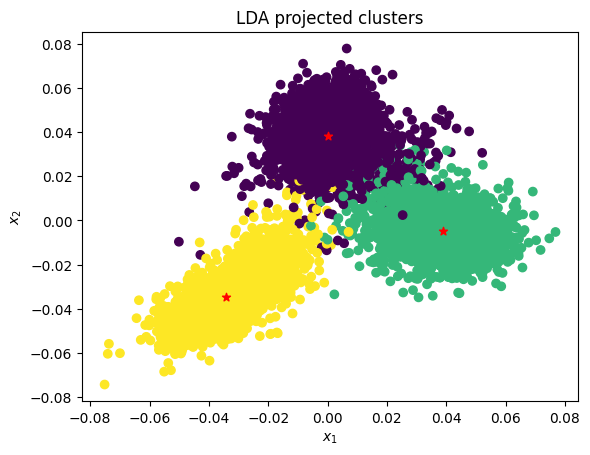

In [22]:
plt.title("LDA projected clusters")
plt.scatter(Z_LDA[0, :], Z_LDA[1, :], c=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
for key, val in Z_LDA_c.items():
    plt.scatter(val[0], val[1], c="red", marker="*", label=key)
plt.show()

In [55]:
LDA_ic_dist = get_intra_cluster_dists(Z_LDA, Z_LDA_c, y_train)
print_intra_cluster_dist(LDA_ic_dist)

Intra cluster distance for:
class 0 	-> 0.012280258298366332
class 6 	-> 0.011427647191348702
class 9 	-> 0.011695345617525534


### PCA

In [62]:
Z_PCA, Z_PCA_c, U_kt = PCA(X_train, y_train, 2)
print("PCA centroids")
print_cluster_centroids(Z_PCA_c)

PCA centroids
Centroids for:
class 0 	-> [898.29928873  32.43287248]
class 6 	-> [-297.04349913  399.32027663]
class 9 	-> [-590.27826566 -420.78362773]


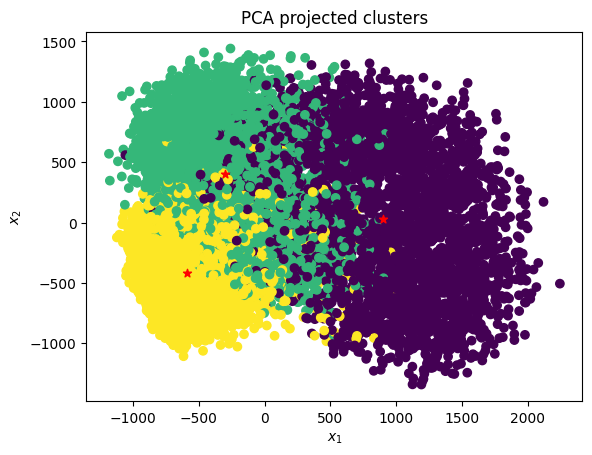

In [25]:
plt.title("PCA projected clusters")
plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
for key, val in Z_PCA_c.items():
    plt.scatter(val[0], val[1], c="red", marker="*", label=key)
plt.show()

In [57]:
PCA_ic_dist = get_intra_cluster_dists(Z_PCA, Z_PCA_c, y_train)
print("LDA on train set")
print_intra_cluster_dist(PCA_ic_dist)

LDA on train set
Intra cluster distance for:
class 0 	-> 734.3232712593631
class 6 	-> 537.4158477950607
class 9 	-> 365.11138301159514


Compute the distance from the centroids on the test set

In [58]:
Z_LDA_test = Q_t @ X_test
LDA_ic_dist_test = get_intra_cluster_dists(Z_LDA_test, Z_LDA_c, y_test)
print("LDA on test set")
print_intra_cluster_dist(LDA_ic_dist_test)

LDA on test set
Intra cluster distance for:
class 0 	-> 0.014395736176983772
class 6 	-> 0.01208768190743485
class 9 	-> 0.01329061917342181


In [59]:
# Center the matrix
X_test_centered = np.array([np.mean(col) for col in X_test])
X_test_centered = (X_test.T - X_test_centered).T

Z_PCA_test = U_kt @ X_test_centered
PCA_ic_dist_test = get_intra_cluster_dists(Z_PCA_test, Z_PCA_c, y_test)
print("PCA on train set")
print_intra_cluster_dist(PCA_ic_dist_test)

PCA on train set
Intra cluster distance for:
class 0 	-> 731.5846505969562
class 6 	-> 538.8936261685511
class 9 	-> 366.5110539597648


### Build a classifier using PCA and LDA

In [29]:
def find_nearest_centroid(point, centroid_dict):
    distance_v = []
    labels = []
    for k in centroid_dict.keys():
        distance_v.append(np.linalg.norm(centroid_dict[k] - point))
        labels.append(k)
    
    return int(labels[distance_v.index(min(distance_v))])

In [30]:
def generic_classifier(Z_c, T_matrix, X_test):
    Z = T_matrix @ X_test
    # Find the nearest centroid
    y_predicted = []
    for point in Z.T:
        y_predicted.append(find_nearest_centroid(point, Z_c))
    
    return np.array(y_predicted)

In [31]:
def PCA_classifier(X_train, y_train, X_test, k=2):
    _, Z_PCA_c, U_kt = PCA(X_train, y_train, k=k)
    # Center the matrix
    X_test_centered = np.array([np.mean(col) for col in X_test])
    X_test_centered = (X_test.T - X_test_centered).T    
    return generic_classifier(Z_PCA_c, U_kt, X_test_centered)

In [32]:
def LDA_classifier(X_train, y_train, X_test, k=2):
    _, Q_t, Z_LDA_c = LDA(X_train, y_train, k=k)
    return generic_classifier(Z_LDA_c, Q_t, X_test)

In [33]:
def compute_accuracy(y_true, y_guess):
    return (len(y_true) - np.count_nonzero(y_true - y_guess)) / len(y_true) * 100

In [34]:
print(f"PCA classifier, test set accuracy on class {np.sort(np.unique(y_train))}, with:")
for k in range(2, 20, 2):
    y_predicted = PCA_classifier(X_train, y_train, X_test, k=k)
    print("k = "+ str(k) + " \t-> " + str(compute_accuracy(y_test, y_predicted)) + " %")

PCA classifier, test set accuracy on class [0 6 9], with:
k = 2 	-> 84.06902086677368 %
k = 4 	-> 94.54253611556982 %
k = 6 	-> 95.14446227929373 %
k = 8 	-> 95.42536115569823 %
k = 10 	-> 95.54574638844302 %
k = 12 	-> 95.62600321027287 %
k = 14 	-> 95.70626003210273 %
k = 16 	-> 95.70626003210273 %
k = 18 	-> 95.70626003210273 %


In [35]:
print(f"LDA classifier, test set accuracy on class {np.sort(np.unique(y_train))}, with:")
for k in range(1, 3, 1):
    y_predicted = LDA_classifier(X_train, y_train, X_test, k=k)
    print("k = "+ str(k) + "\t-> " + str(compute_accuracy(y_test, y_predicted)) + " %")

LDA classifier, test set accuracy on class [0 6 9], with:
k = 1	-> 93.57945425361156 %
k = 2	-> 97.9935794542536 %


## Visualizing a dyad

In [63]:
import skimage.data
from skimage import color

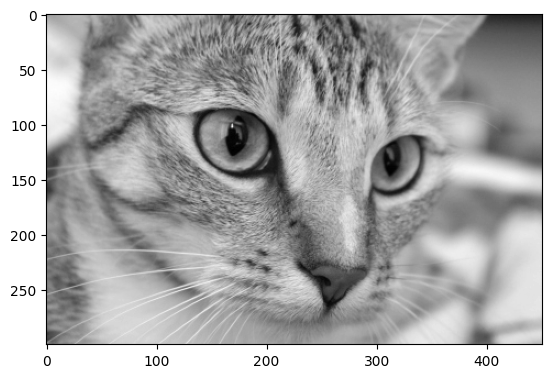

In [64]:
X = skimage.data.cat()
X = color.rgb2gray(X)
plt.imshow(X, cmap="gray")
plt.show()

In [65]:
# Compute SVD
svd_m = np.linalg.svd(X, full_matrices=False)

In [66]:
U, s, v = svd_m
U.shape, s.shape, v.shape

((300, 300), (300,), (300, 451))

In [67]:
def get_ith_dyad(i, svd_m):
    U, s, v = svd_m
    return s[i] * (U[:, i].reshape((-1, 1)) @ v[i, :].reshape((1, -1)))

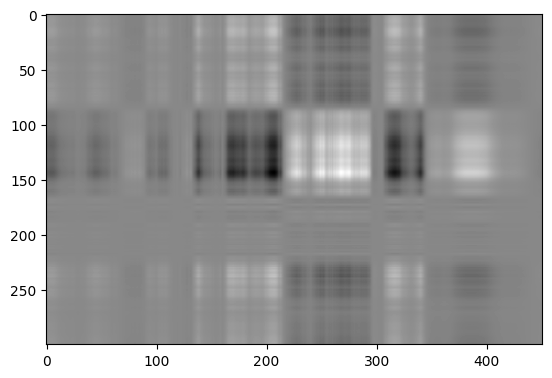

In [68]:
plt.imshow(get_ith_dyad(2, svd_m), cmap="gray")
plt.show()

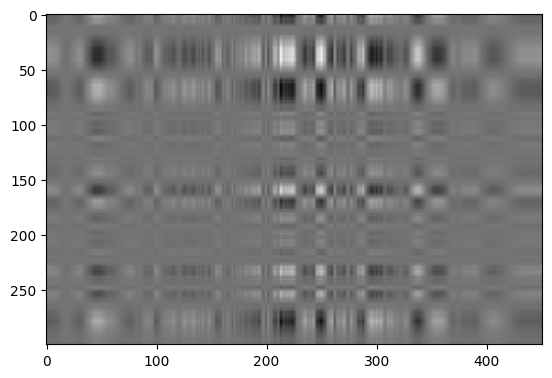

In [69]:
plt.imshow(get_ith_dyad(10, svd_m), cmap="gray")
plt.show()

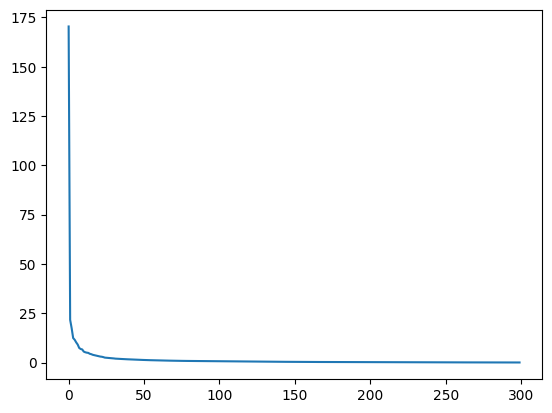

In [70]:
plt.plot(s)
plt.show()

In [44]:
def k_val_image_approximation(img, k):
    # Compute SVD
    svd_m = np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
    app_img = get_ith_dyad(0, svd_m)
    for i in range(1, k-1):
        app_img = app_img + get_ith_dyad(i, svd_m)
    return app_img

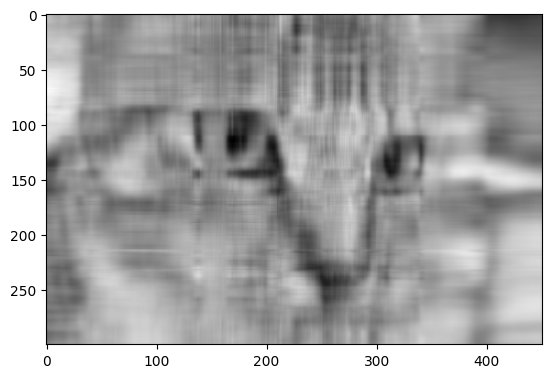

In [71]:
plt.imshow(k_val_image_approximation(X, 10), cmap="gray")
plt.show()

In [46]:
approx_range = range(1, 200, 2)
approx_error = [np.linalg.norm(X - k_val_image_approximation(X, k)) for k in approx_range]

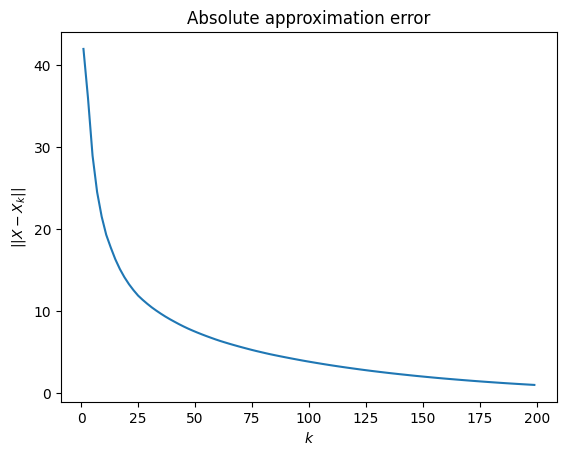

In [81]:
plt.title("Absolute approximation error")
plt.plot([k for k in approx_range], approx_error)
plt.xlabel("$k$")
plt.ylabel("$||X - X_k||$")
plt.show()

In [82]:
m, n = X.shape
compression_factor = [k*(m + n + 1)/(m * n) for k in approx_range]

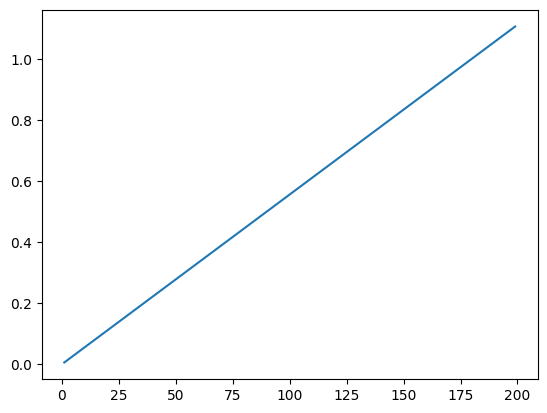

In [83]:
plt.plot([k for k in approx_range], compression_factor)
plt.show()